<a href="https://colab.research.google.com/github/PhanThanhSum/C1025L1-JV105/blob/main/Training_l%E1%BA%A7n_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/training_classification_model

/content/drive/.shortcut-targets-by-id/16FUP6ewnT8F2_T5rppOYmfZb5x5eAgAh/training_classification_model


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
from tqdm import tqdm
import os

In [ ]:
# ===============================
# 1️⃣ Thiết lập thông số cơ bản
# ===============================
DATA_DIR = "/content/drive/MyDrive/Dataset_Final_Split_Small"
BATCH_SIZE = 64
IMG_SIZE = 224
EPOCHS = 10
LEARNING_RATE = 1e-4
#LEARNING_RATE = 1e-5  # Đã giảm learning rate để mô hình học chậm hơn
NUM_CLASSES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# ===============================
# 2️⃣ Tạo transform cho ảnh
# ===============================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# ===============================
# 3️⃣ Load dataset
# ===============================
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'Train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'Validate'), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'Test'), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
# ===============================
# 4️⃣ Tạo mô hình Swin Transformer Small
# ===============================
model = create_model('swin_small_patch4_window7_224', pretrained=True, num_classes=NUM_CLASSES)
model.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [ ]:
# ===============================
# 5️⃣ Cấu hình optimizer & loss
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# ===============================
# 6️⃣ Hàm train & validate
# ===============================
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    return running_loss / total, correct / total

In [ ]:
import copy

# ===============================
# 7️⃣ Vòng lặp huấn luyện
# ===============================
best_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# Thêm Early Stopping
patience = 3  # Số epoch chờ đợi nếu val_acc không cải thiện (điều chỉnh cho mô hình hội tụ nhanh)
counter = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_swinS_food.pth")
        counter = 0 # Reset counter nếu accuracy cải thiện
    else:
        counter += 1 # Tăng counter nếu accuracy không cải thiện

    if counter >= patience:
        print(f"Early stopping triggered after {patience} epochs without improvement.")
        break

print("✅ Huấn luyện hoàn tất. Best validation acc:", best_acc)

Epoch [1/10]
  Train Loss: 0.4854 | Train Acc: 0.8543
  Val   Loss: 0.1460 | Val   Acc: 0.9618


Epoch [2/10]
  Train Loss: 0.1136 | Train Acc: 0.9675
  Val   Loss: 0.1112 | Val   Acc: 0.9702


Epoch [3/10]
  Train Loss: 0.0597 | Train Acc: 0.9835
  Val   Loss: 0.1233 | Val   Acc: 0.9603


Epoch [4/10]
  Train Loss: 0.0385 | Train Acc: 0.9900
  Val   Loss: 0.1237 | Val   Acc: 0.9695


Epoch [5/10]
  Train Loss: 0.0342 | Train Acc: 0.9909
  Val   Loss: 0.1462 | Val   Acc: 0.9626
Early stopping triggered after 3 epochs without improvement.
✅ Huấn luyện hoàn tất. Best validation acc: 0.9702290076335878


In [ ]:
#torch.save(model, "model_full.pth")

In [ ]:
# ===============================
# 8️⃣ Đánh giá trên test set
# ===============================
model.load_state_dict(torch.load("best_swinS_food.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"🎯 Test Accuracy: {test_acc:.4f}")

🎯 Test Accuracy: 0.9553


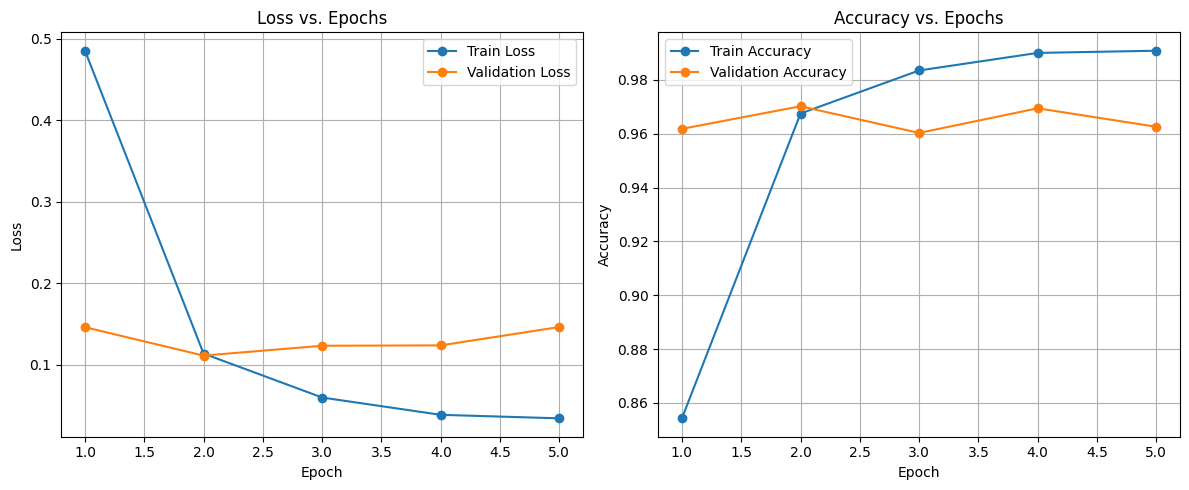

In [ ]:
# ===============================
# Vẽ biểu đồ Loss và Accuracy
# ===============================
import matplotlib.pyplot as plt

# Sử dụng số lượng epoch thực tế đã hoàn thành
epochs_completed = range(1, len(train_losses) + 1)

plt.figure(figsize=(12,5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_completed, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_completed, val_losses, label='Validation Loss', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_completed, train_accs, label='Train Accuracy', marker='o')
plt.plot(epochs_completed, val_accs, label='Validation Accuracy', marker='o')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

🧾 Classes: ['Banh beo', 'Banh bot loc', 'Banh can', 'Banh gio', 'Banh mi', 'Banh xeo', 'Bun rieu', 'Ca kho to', 'Canh chua', 'Goi cuon']


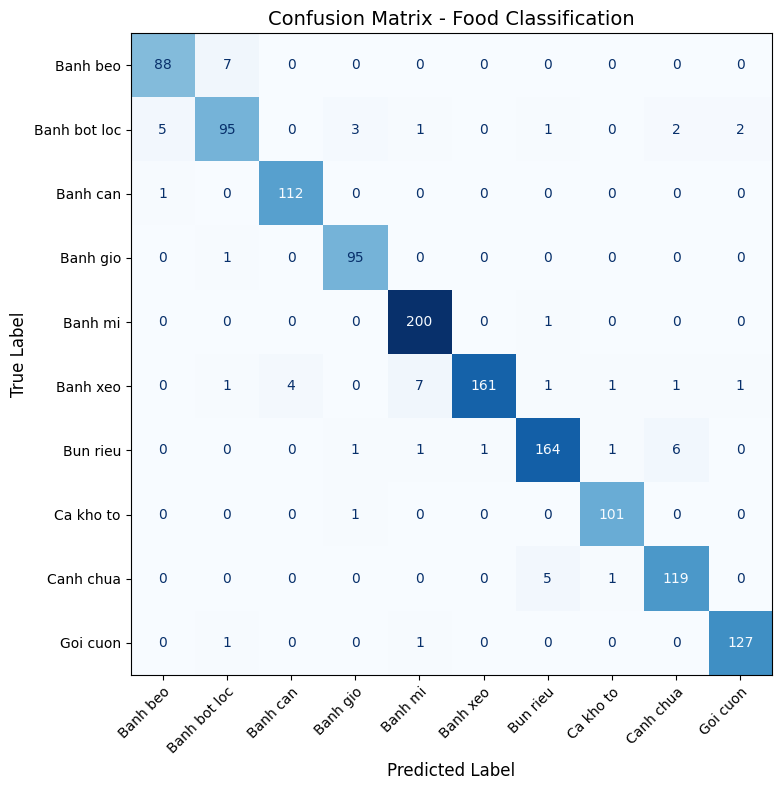

In [ ]:
# ===============================
# Vẽ ma trận nhầm lẫn (Confusion Matrix)
# ===============================
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Nếu bạn dùng ImageFolder, thứ tự class là theo alphabet của thư mục train/
train_dir = "/content/drive/MyDrive/Dataset_Final_Split_Small/Train"
class_names = sorted(os.listdir(train_dir))
print("🧾 Classes:", class_names)

# Tính prediction và label thực
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Ma trận nhầm lẫn
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Vẽ ma trận nhầm lẫn với góc nghiêng cho nhãn
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Food Classification", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

# Xoay chữ ở trục X (Predicted labels)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

plt.tight_layout()
plt.show()


**Code infer dự đoán 1 ảnh**

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
from timm import create_model
import os

# ===============================
# 1️⃣ Thông số cơ bản
# ===============================
MODEL_PATH = "best_swinS_food.pth"
IMG_PATH = "Test_109.jpg"  # ảnh bạn muốn dự đoán
NUM_CLASSES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ===============================
# 2️⃣ Load danh sách class
# ===============================
# Nếu bạn dùng ImageFolder, thứ tự class là theo alphabet của thư mục train/
train_dir = "/content/drive/MyDrive/Dataset_Final_Split_Small/Train"
class_names = sorted(os.listdir(train_dir))
print("🧾 Classes:", class_names)

# ===============================
# 3️⃣ Tạo model và load trọng số
# ===============================
model = create_model('swin_small_patch4_window7_224', pretrained=False, num_classes=NUM_CLASSES)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.to(DEVICE)
model.eval()

# ===============================
# 4️⃣ Chuẩn bị ảnh đầu vào
# ===============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

image = Image.open(IMG_PATH).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(DEVICE)

# ===============================
# 5️⃣ Dự đoán
# ===============================
with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)
    pred_class = class_names[predicted.item()]

print(f"🍲 Dự đoán: {pred_class}")


🧾 Classes: ['Banh beo', 'Banh bot loc', 'Banh can', 'Banh gio', 'Banh mi', 'Banh xeo', 'Bun rieu', 'Ca kho to', 'Canh chua', 'Goi cuon']
🍲 Dự đoán: Banh beo
